In [43]:
pip install pyspark

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# **1. Movie Recommendation with Pyspark** 


First, we need to create a spark container by calling SparkSession. This step is necessary before doing anything

In [45]:
# Create SparkSession
spark = SparkSession.builder.appName('recommender_system').getOrCreate()

### Pyspark.toPandas() method allow us to return SparkDataFrame as Pandas table display

In [46]:
# load the dataset and create sprk dataframe
df=spark.read.csv(r'C:\Users\Sebi-PC\Desktop\Project Python\Project3\PySpark\Movie\movie_ratings_df.csv',inferSchema=True,header=True)
# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table
df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


## Our task: given a user, we predict and return a list of movies recommendation for that user to watch.

### We use: **printSchema()** to quick overview of features datatype

In [47]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



### As we can see, the title column is stored as string type. To work with pyspark Mlib library, we need to convert string type to numeric values

In [48]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
# Applying stringindexer object on dataframe movie title column
model = stringIndexer.fit(df)
#creating new dataframe with transformed values
indexed = model.transform(df)
#validate the numerical title values
indexed.limit(5).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


### We use Alternating least squares (ALS) algorithm in Pyspark Ml library for recommendation. To read more, you can visit at https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html

In [49]:
# split the data into training and test datatset
train, test = indexed.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Training the recommender model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set 
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,243,Much Ado About Nothing (1993),4,148.0,4.039844
1,642,Much Ado About Nothing (1993),5,148.0,4.243425
2,436,Much Ado About Nothing (1993),5,148.0,4.257206
3,497,Much Ado About Nothing (1993),2,148.0,4.169375
4,417,Much Ado About Nothing (1993),5,148.0,4.282906


### Evaluate the training

In [50]:
# Importing Regression Evaluator to measure RMSE
from pyspark.ml.evaluation import RegressionEvaluator
# create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
# apply the RE on predictions dataframe to calculate RMSE
rmse=evaluator.evaluate(predicted_ratings)
# print RMSE error
print(rmse)

1.012278955750076


### After training, now is the time to recommend top movies which user might like 

In [51]:
# First we need to create dataset of all distinct movies 
unique_movies=indexed.select('title_new').distinct()

#create function to recommend top 'n' movies to any particular user
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like 
    
    """
    #assigning alias name 'a' to unique movies df
    a = unique_movies.alias('a')
    
    #creating another dataframe which contains already watched movie by active user 
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')
    
    #assigning alias name 'b' to watched movies df
    b=watched_movies.alias('b')
    
    #joining both tables on left join 
    total_movies = a.join(b, a.title_new == b.title_new,how='left')
    
    #selecting movies which active user is yet to rate or watch
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    
    
    #adding new column of user_Id of active useer to remaining movies df 
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))
    
    
    #making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)
    
    
    #adding columns of movie titles in recommendations
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [52]:
# Test: recommend 5 movies for user of id=60
top_movies(60,5)

+---------+------+----------+---------------------------------------+
|title_new|userId|prediction|title                                  |
+---------+------+----------+---------------------------------------+
|1195.0   |60    |6.1945705 |Love and a .45 (1994)                  |
|1054.0   |60    |5.6852307 |Primary Colors (1998)                  |
|926.0    |60    |5.65794   |Ma vie en rose (My Life in Pink) (1997)|
|1393.0   |60    |5.6073236 |Schizopolis (1996)                     |
|1463.0   |60    |5.5853505 |American Dream (1990)                  |
+---------+------+----------+---------------------------------------+



# **2. Classification model in Pyspark** 

We using Titanic dataset for familiar playing with data based on Pyspark DataFrame

## **2.1 EDA in Pyspark** 



In [53]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv(r'C:\Users\Sebi-PC\Desktop\Project Python\Project3\PySpark\Titanic\train.csv',header = 'True',inferSchema='True')

In [54]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [55]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### For visualization,before using visual library (matplotlib, seaborn, ..)we need to convert SparkDataframe to PandasDataFrame 

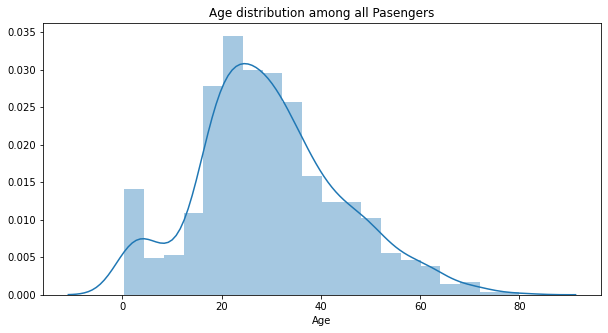

In [56]:
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distribution among all Pasengers')
sns.distplot(pandas_df['Age']);

## Checking null values in Pyspark

* isnan() is a function of the pysparq.sql.function package, we have to set which column we want to use as an argument of the function. 
* isNull()" belongs to pyspark.sql.Column package, to check the null status of a column

To check null in Pyspark, we use both function above

In [57]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [58]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
df = df.drop("Cabin")

To replace these NaN values, we can assign them the mean age of the dataset.But the problem is, there were many people with many different ages. 

In 'Name' feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups

**Using the Regex ""[A-Za-z]+)." we extract the initials from the Name. It looks for strings which lie between A-Z or a-z and followed by a .(dot).**

In [59]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [60]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [61]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [62]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



### We using PysparkDataFrame.na.fill() to fill a value to specific column

In [63]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked" : 'S'})
# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



#### After handling missing values, we do some simple feature engineering
#### in Feature engineering, we can use Pyspark multiple condition with syntax: "When otherwise"
#### To learn more about multiple condition in pyspark, you can visit at https://sparkbyexamples.com/spark/spark-case-when-otherwise-example/

In [64]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
df = df.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [65]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [66]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [67]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

In [68]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



## **2.2 Machine learning in pyspark** 




### Just for practising, I'll use some of learning algorithm

1. LogisticRegression
 
2. RandomForestClassifier

In [69]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

## Logistic regression

In [80]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))


Accuracy:  0.7954545454545454
Precision:  0.7972450343773873


### Evaluating ROC metric

In [81]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.8474997779554138


### Visualizing AUC metrics

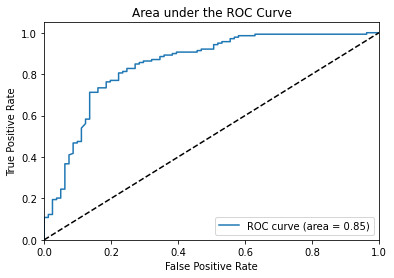

In [82]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [83]:

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8090909090909091
Precision:  0.8070595611285267


### Evaluating ROC metrics

In [84]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.84723332445155


### Visualizing AUC metrics

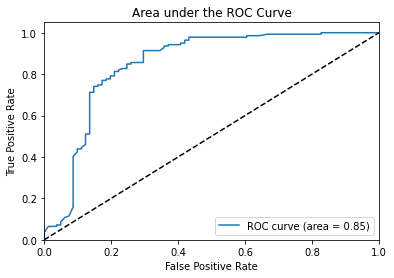

In [85]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

I hope you find this notebook beneficial and enjoyable